PSF Photometry
======

**Version 0.1**

We're going to try to piece together the different elements of a PSF photometry pipeline from scratch. Getting that done in one notebook means we'll have to cut some corners, but the process should be illustrative.

We will start with an image that has already been processed by the LSST pipelines, so all the calibration steps like bias subtraction, flat fielding, background subtraction, etc (together often called "instrumental signature removal") have been performed, and the image is ready for measurement.

Please download the [calibrated image](https://northwestern.box.com/s/0sidhj7yk64td5a3tmu0vzh3duju4dpe). 

* * *

By C Slater (University of Washington)

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.convolution

import pandas as pd

In [2]:
f = fits.open("calexp-0527247_10.fits")
image = f[1].data

In [4]:
%matplotlib notebook

0) Finding an example star
-----

I think a good way to work on a problem like this is to start with the core of the algorithm, working on just a single test case. After we have that working and tested, we can build out the infrastructure around it to run on the entire image.

Let's display a small subset of the image, say 400x400 pixels. By default, `imshow()` will scale the colorbar to the minimum and maximum pixel values, so let's also set some more reasonable limits so we can see some stars.

We also need to use the `extent=` keyword argument to `imshow()` so that the labels on the X and Y axes correspond to the pixel coordinates that we've selected.

You can also open the images in ds9 if you like, for easier browsing.

<IPython.core.display.Javascript object>


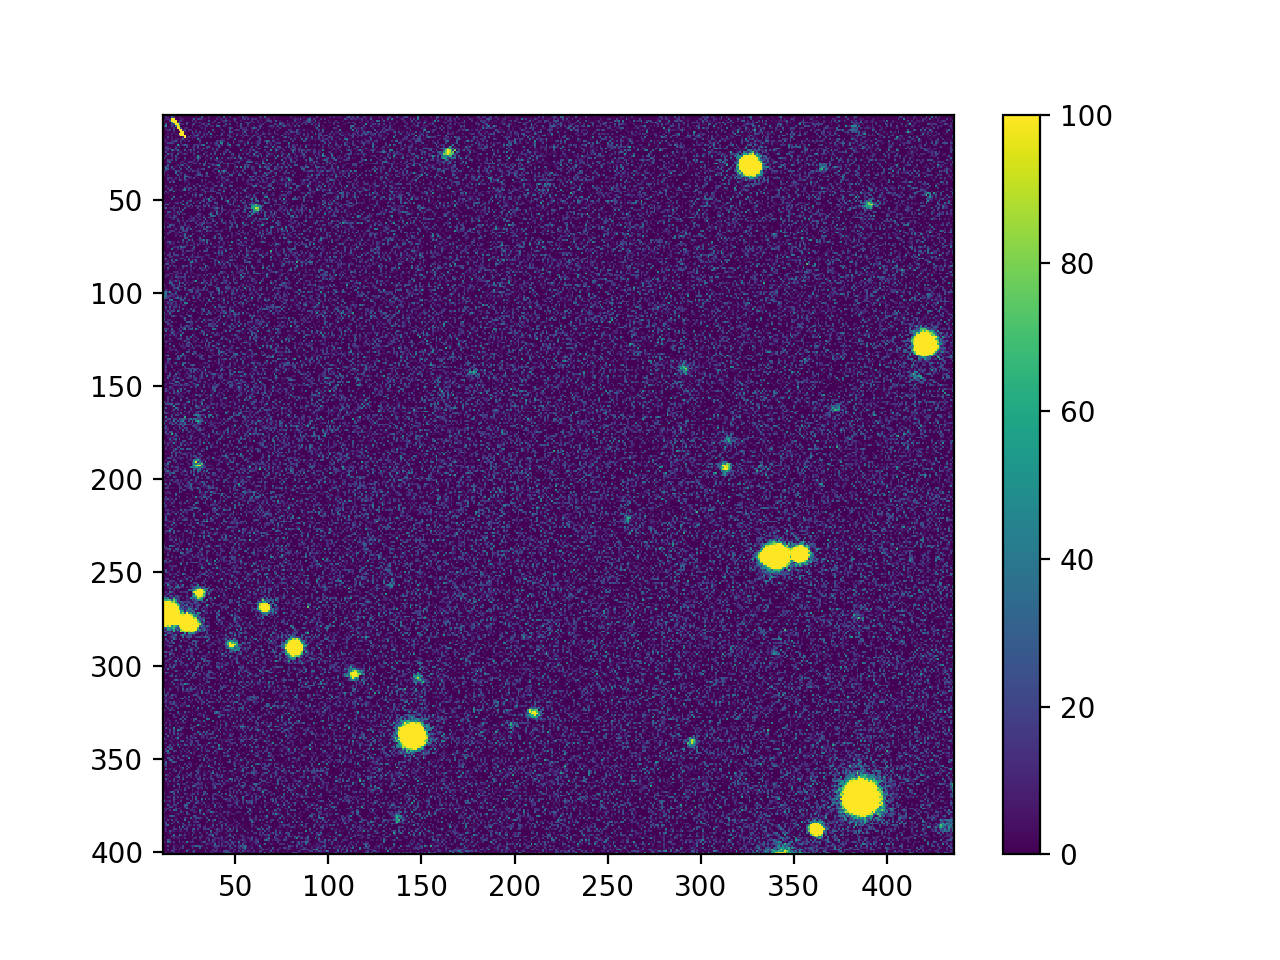

In [38]:
plt.imshow(image, # complete
           vmin=0,
           vmax=100
    )
plt.colorbar()

<IPython.core.display.Javascript object>


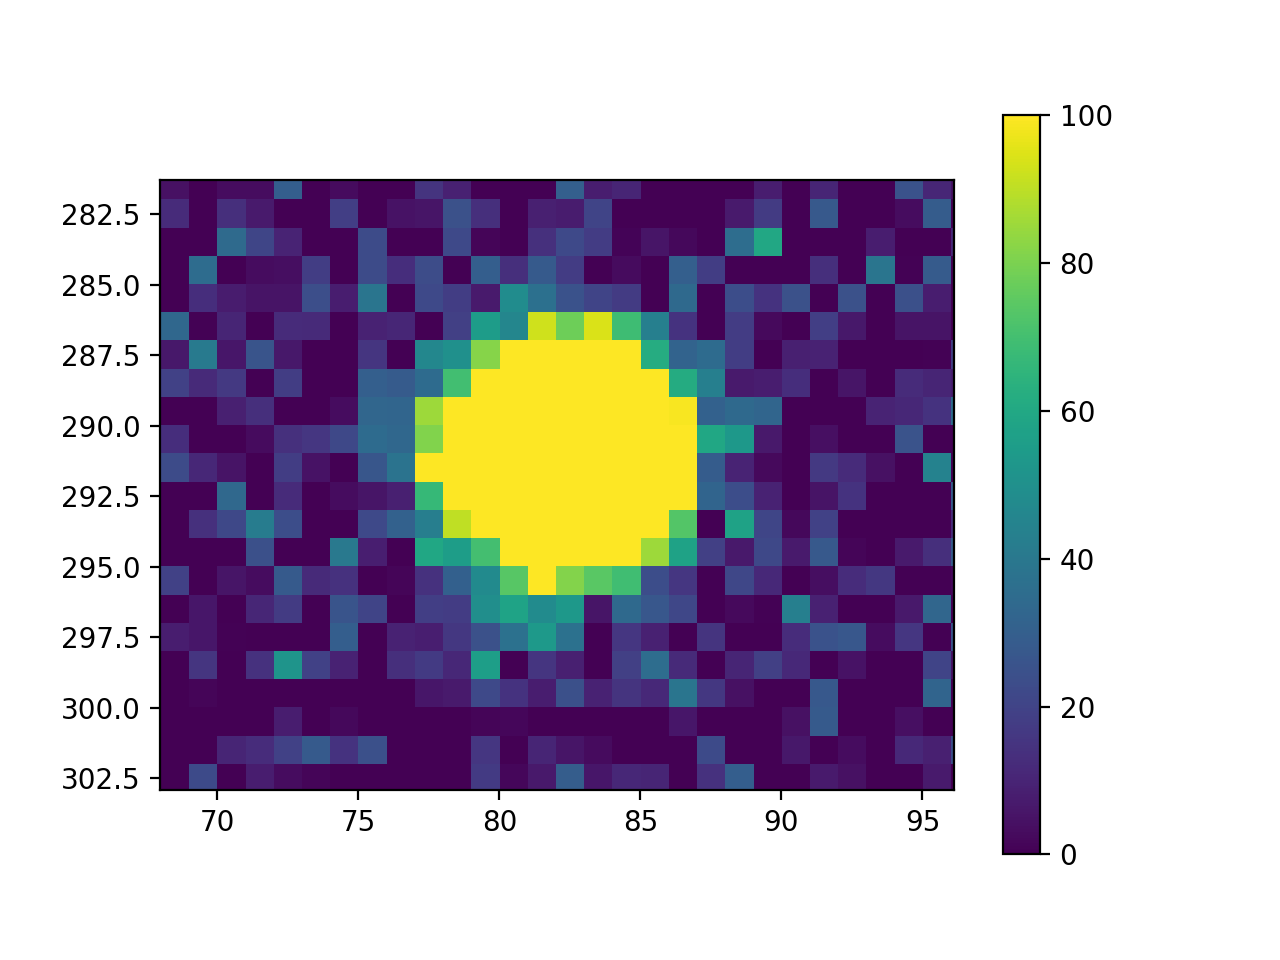

In [48]:
#Question
plt.imshow(image[:400,:400], # complete
           extent=(0,400,400,0), # complete
           vmin=0,
           vmax=100
    )
plt.colorbar()

Now let's select a smaller region around something that looks like a good, isolated star. Remember to update the `extent` so we know which pixels we're looking at.

<IPython.core.display.Javascript object>


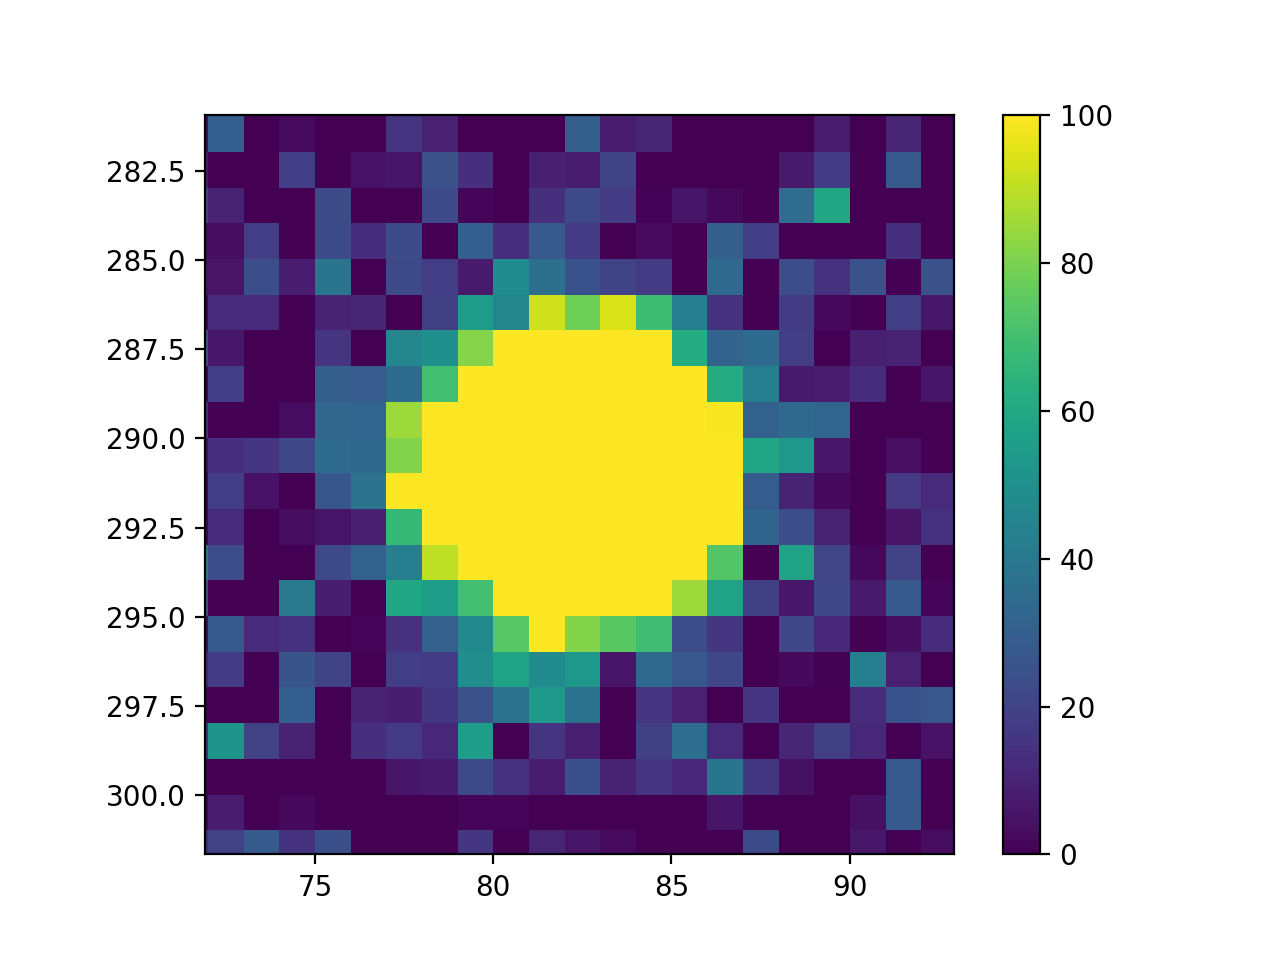

In [45]:
# Question
plt.imshow(image[275:305,65:100], # complete
          extent=(65,100,305,275),# complete
            vmin=0,
           vmax=100
    )
plt.colorbar()

Ok, we need to cut down the image one more time, this time to give us a "cutout" image of a single star-like object. The cutout should only be about 20x20 pixels.

<IPython.core.display.Javascript object>


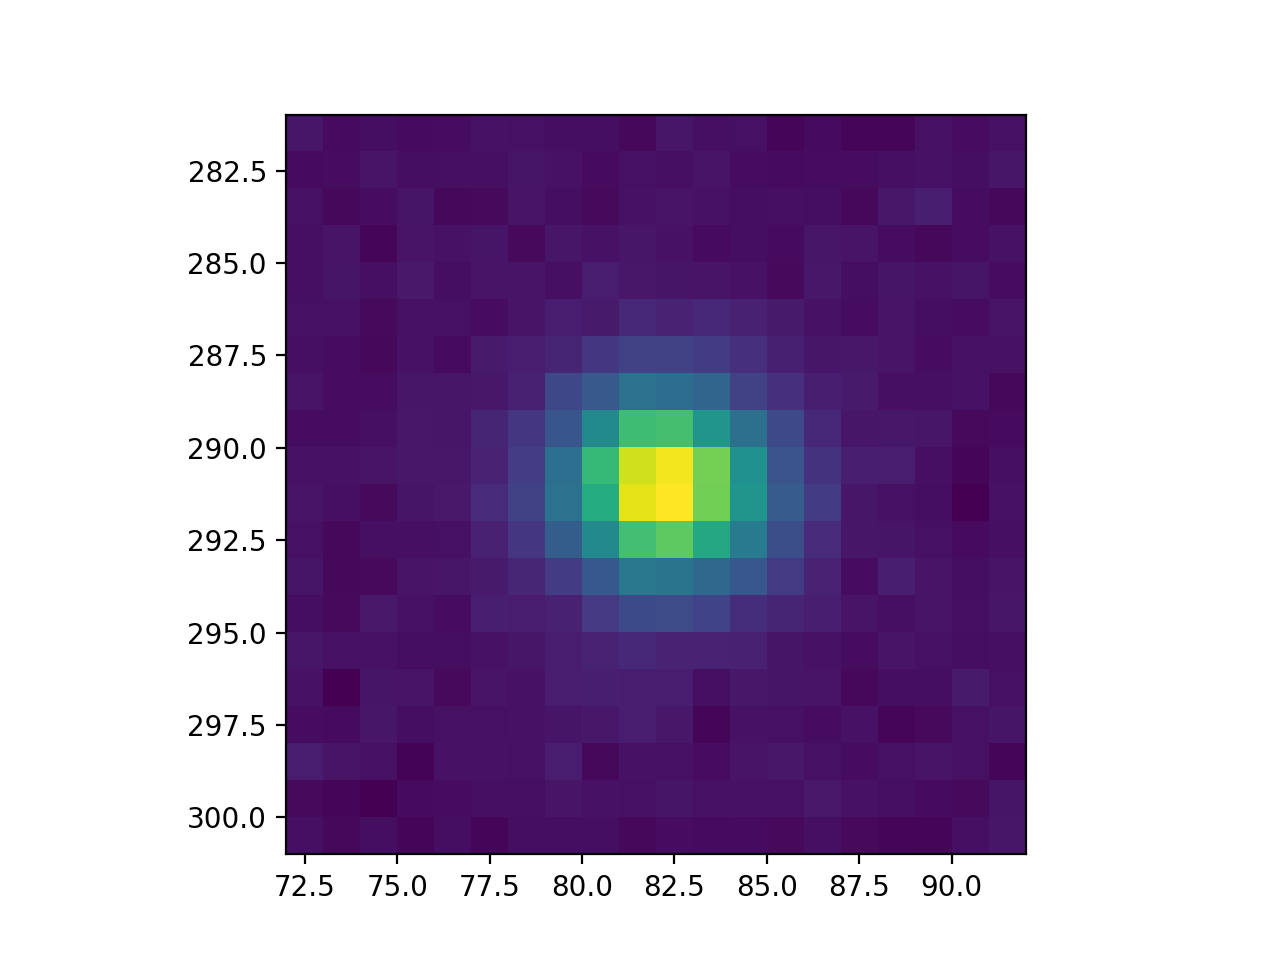

In [57]:
# Question
cutout = image[281:301,72:92] # complete
plt.imshow(cutout,extent=(72,92,301,281)) #complete

1) Centroiding
--------

Now that we have a test case to work on, let's find its position on the CCD.

To do that, we're going to need two arrays: one which has the same shape as `cutout`, but where each value is the X coordinate of the pixel, and another where each value is the Y coordinate of the pixel. Numpy has a function called `meshgrid()` that will give us this; we just need to supply an iterator for the X values, and an iterator for the Y values. It looks like this:

In [54]:
xx, yy = np.meshgrid(range(2, 10), range(20, 30))
print("xx: ", xx)
print("yy: ", yy)

xx:  [[2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]
 [2 3 4 5 6 7 8 9]]
yy:  [[20 20 20 20 20 20 20 20]
 [21 21 21 21 21 21 21 21]
 [22 22 22 22 22 22 22 22]
 [23 23 23 23 23 23 23 23]
 [24 24 24 24 24 24 24 24]
 [25 25 25 25 25 25 25 25]
 [26 26 26 26 26 26 26 26]
 [27 27 27 27 27 27 27 27]
 [28 28 28 28 28 28 28 28]
 [29 29 29 29 29 29 29 29]]


Note how the values in a column are the same in `xx`, and all the values in a row are the same in `yy`.

Let's make an `xx` and `yy` with the values corresponding to the pixel coordinates in your cutout image. 

In [55]:
# Question
xx, yy = np.meshgrid(range(72, 92), range(281, 301)) # complete
print("xx: ", xx)
print("yy: ", yy)

xx:  [[72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 

Now we're ready to compute the centroid. Let's compute it first in x: we want the weighted mean of xx, with our `cutout` image as the weights. Remember to normalize by the sum of `cutout` values. The same formula will apply for y.

In [56]:
# Question
x_center = np.sum(xx*cutout)/np.sum(cutout)# complete
y_center = np.sum(yy*cutout)/np.sum(cutout)# complete

print(x_center, y_center)

81.7511616195688 290.56209210992546


Do the values you got make sense? Are they within the range of x and y coordinate values of the cutout? Does it roughly match where the star is? If not, are they possibly swapped, x-for-y and y-for-x? (It's very easy to get confused with the ordering of x and y indicies in Numpy, I make that mistake all the time).

If they make sense, try overplotting the coordinates on one of your larger cutout images.


<IPython.core.display.Javascript object>


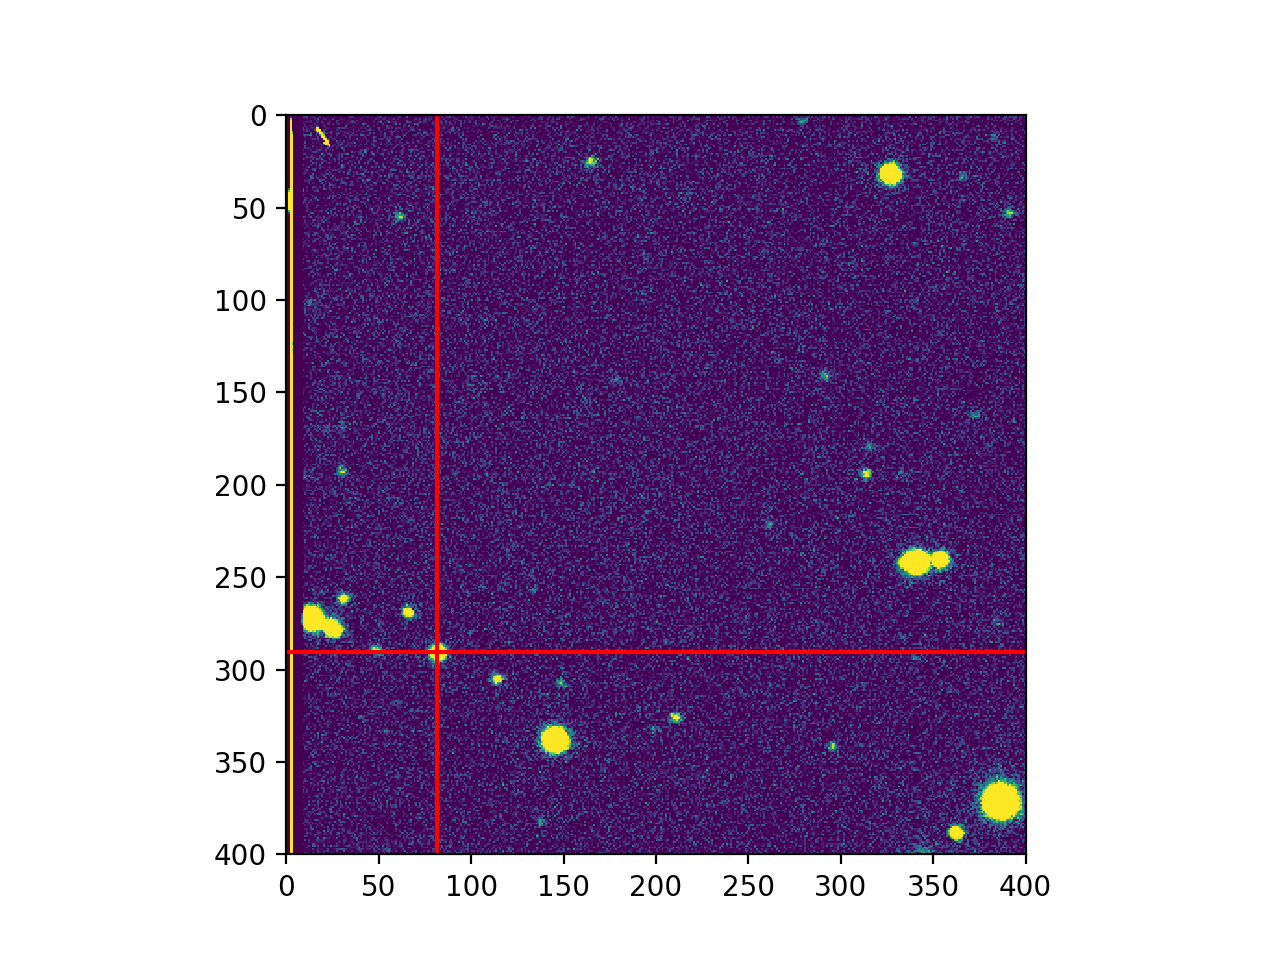

In [58]:
# Question
plt.imshow(image[:400,:400], # complete
           extent=(0,400,400,0), # complete
           vmin=0,
           vmax=100 # complete
          # complete
    )
plt.axvline(x_center, color='r')
plt.axhline(y_center, color='r')

If your lines cross on your chosen star, great! You've completed the first step of doing photometry, centroiding the object.

Let's take the code you prototyped in the notebook cells, and wrap it into a nice function we can use later. When we call this function, we need to tell it about the coordinates of the image we're providing, so we'll add the `x_start` and `y_start` parameters to convey that. We don't need to know the other two corners, because we can figure that out from the size of `image_cutout`.

In [59]:
# Question
def centroid(image_cutout, x_start, y_start):
    x_size, y_size = image_cutout.shape
    xx, yy = np.meshgrid(range(x_start, x_start+x_size), range(y_start, y_start+y_size))# complete
    x_center = np.sum(xx*cutout)/np.sum(cutout)# complete
    y_center = np.sum(yy*cutout)/np.sum(cutout)# complete
    return (x_center, y_center)

2) PSF Photometry
-----

We needed the centroid first, because we're going to use that position to place our "PSF" model. Since we have not yet fit a real PSF model to the sources in the image, we'll use a Gaussian as an approximation.

I'll give you the function for a normalized 2D Gaussian:

In [60]:
def gaussian2D(radius, mu):
    return 1/(mu**2*2*np.pi)*np.exp(-0.5*((radius)/mu)**2)

First just make an image of an example PSF, on the same grid as the `cutout`. 

Note that the Gaussian is parameterized in terms of a radius, which means you will need to compute that radius from the position of every pixel in your image. `meshgrid` is again the tool for this.

You can either use your `centroid()` function here, or for debugging it's fine to manually set `x_center` and `y_center` to specific values.

<IPython.core.display.Javascript object>


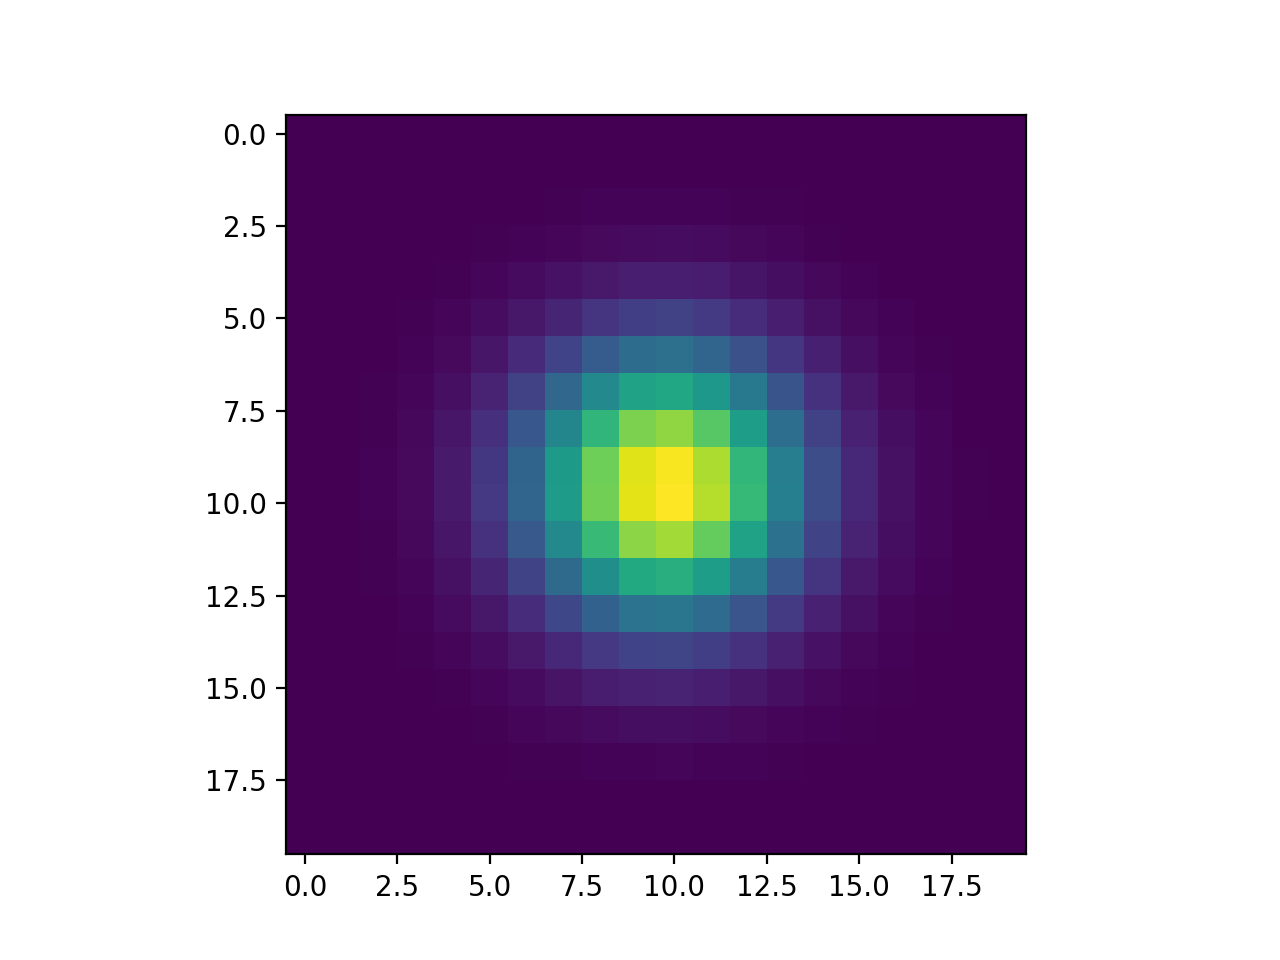

In [69]:
xx, yy = np.meshgrid(range(72, 92), range(281, 301))  # complete 
x_center, y_center = centroid(cutout, np.min(xx), np.min(yy)) # complete
radius = np.sqrt((xx-x_center)**2 # complete
                 + (yy-y_center)**2 # complete
                 )

psf_size_pixels = 2.5
psf_image = gaussian2D(radius,psf_size_pixels) # complete
plt.imshow(psf_image) # Complete 

Just to be sure, we should check that the PSF image is normalized (approximately) by summing the pixel values.

In [70]:
# Question
np.sum(psf_image)
# Complete

0.999881446455592

Ok, now we can compute the actual PSF flux. Remember the formula from the lecture is:


$$ f_{\rm ML}(x, y) = \frac{\sum_i \hat{f}_i p_i(x,y)}{\sum_i p_i^2(x, y)}$$

where $\hat{f_i}$ are your image values, and $p_i$ are are your PSF model values.

In [71]:
# Question
psf_flux = np.sum(cutout*psf_image)/np.sum(psf_image**2)# complete
print(psf_flux)

35281.38404346415


Double check that the PSF flux you get matches (approximately) the flux you get from aperture photometry. If your cutout image is small enough that there are no other sources in it, you can just sum the cutout itself. No need to apply a more restrictive aperture for a debugging check like this.

In [72]:
# Question
aperture_flux = np.sum(cutout) # complete
print(aperture_flux)

30773.28


If your `psf_flux` reasonably matches your `aperture_flux`, well done! You have a working PSF photometry measurement, now it just needs to get wrapped up in a convenient function for later use. <br/>

AC: **Close enough!!! lol**

In [75]:
# Question

# We need to pass both the centroid x and y, and the image cutout start x,y because the star
# isn't necessarily at the very center of the cutout.

def psf_flux_gaussian(image_cutout, centroid_x, centroid_y, radius, x_start, y_start):
    
    x_size, y_size = image_cutout.shape# complete
    xx, yy = np.meshgrid(range(x_start, x_start+x_size), range(y_start, y_start+y_size))# complete
    x_center, y_center = centroid(image_cutout, np.min(xx), np.min(yy)) # complete
    r = np.sqrt((xx-x_center)**2 # complete
                 + (yy-y_center)**2 # complete
                 )
    psf_image = gaussian2D(r,radius) # complete
    psf_flux = np.sum(image_cutout*psf_image)/np.sum(psf_image**2) # complete
    return psf_flux

3) Object Detection
------

Now that we have the core of the algorithm, we need to improve on our earlier step where we hand-picked a single source to measure. 

We know from the talk on object detection that we need to convolve the image with the PSF to detect sources. Of course, we don't yet know what the PSF is, so we'll guess and use a Gaussian again.

With the convolved image, we now need to find "peaks". That is, we want to find __pixels whose value is greater than all of their immediate neighbors__. That's a relatively easy way to make sure we (mostly) only try to run photometry once on each star.

We are also applying a threshold; if a pixel value is below this threshold, we don't bother checking if it's a peak. That's useful 
to exclude faint background fluctuations that aren't statistically significant (below 5-sigma), or we might set the threshold higher if if we want only bright stars for PSF determination.

The edges of the sensor often contain various artifacts, so you might want to exclude 5 to 10 pixels around each edge from the search.

Programming note: we're going to do a python loop over all the pixels in the image. This is a really slow way to do this, and you should try to avoid loops like this as much as possible in python. We're doing it this way only because 1) it's illustrative and 2) it takes less than a minute; acceptable for a notebook, but not how we process LSST.

In [ ]:
# Question
def find_peaks(image, threshold):
    # We are going to append the peaks we find to these two lists
    peak_x_values = [] 
    peak_y_values = []

    for i in # complete 
        for j in # complete
            pixel = image[i,j]

            # We want to skip over pixels that are below our threshold
            if(pixel # complete
            
            # We want to save pixel coordinates if the pixel is a "peak"
            if(pixel > # Complete
               and pixel > # complete
               and
               # complete
                ):
                # complete
                
    # Now that we're done appending to them, it will be easier if we turn the
    # lists into numpy arrays.
    return np.array(peak_x_values), np.array(peak_x_values)


To use the peak-finder, we need to create a "detection image" by convolving the real image with the PSF. Of course, we don't know the PSF yet, so you can substitute a guess: try a Gaussian kernel, with a 2.5 pixel width.

The `%%time` "magic" will show us how long the convolution and peak-finding took.

In [ ]:
%%time

# Question

convolved_image = astropy.convolution.convolve( # complete

peak_x_values, peak_y_values = # complete

Let's plot the positions of the peaks on the image, to make sure they look reasonable

In [ ]:
# Question

plt.plot( # Complete

A good debugging check is to look at a few cutouts centered on your newly-found detections. You can flip through a few of these by changing the value of `n`.

In [ ]:
# question

n = 50
peak_x = peak_x_values[n]
peak_y = peak_y_values[n]
cutout = image[ # complete
    
plt.imshow(cutout)

4) Photometry on all objects
-------

You're almost finished, the only remaining task is to put together all the different pieces from above into one function that finds sources and measures their sizes and fluxes, and outputs a data table at the end.

For the moment, I will tell you that the Gaussian PSF size is 2 pixels. If you have more time, there's an "extra credit" problem at the end of the notebook that will show you how to measure the PSF size directly, which also lets you measure object sizes in general. But try to get the PSF photometry working first before going onto that.


In [ ]:
# Question

def run_photometry(image, threshold, psf_width):
    
    # Detect your sources
    
    
    # Setup any variables you need to store results.
    for # complete
    
        # Measure the centroid
        
        # Measure the flux
        
        # Measure the moments
        
    # Let's return a pandas DataFrame to make it easy to use the results
    return pd.DataFrame( # complete
    

With that function all filled in, let's run it on the image!

In [ ]:
%%time
# Question

photometry_table = run_photometry( # complete
print(photometry_table)

In [ ]:
print(photometry_table[:20])

Did you get a table full of photometry? If so, great! If it's not working well, it's likely to be a problem with getting the right inputs to the different functions you're calling. You've tested all the steps separately, so they should be working. Getting the right indices on your image cutout is always a tricky part.

If you have extra time, try adding an aperture photometry function to the processing.  You can plot the size (from the second moment) against flux to find what objects might be galaxies, and generate the cutout image to see if they're really galaxies. 

Extra Credit: Measuring the PSF
-----

Once we have sources identified in an image, we want to identify which would be good for PSF determination, and then we want to measure their PSFs. In our case we're going to do both of these at once, we're going to measure sizes for all sources, and then use the mean size of those which we think are stars as our PSF model. In a more sophisticated pipeline, the object sizes might be used as a cut before passing to some more complicated PSF determination process.

To obtain object sizes, we're going to measure the "second moment".

This will look a lot like the centroid algorithm. The formula we want to implement is:

$$I_{xx}^2 =  \frac{\sum_i (\hat{f_i} (x_i - x_{\rm center}))^2}{\sum_i \hat{f_i}^2} $$

Let's try building it directly in the function this time; if it gives you trouble, feel free to try it out in some notebook cells directly (so you can see the intermediate variables better) before putting it back in the function.

In [ ]:
# Question
def second_moment(image_cutout, centroid_x, centroid_y, start_x, start_y):
    x_size, y_size = # complete
    xx, yy =  # complete
    x_width = # complete
    y_width = # complete
    return (x_width, y_width)


Let's run the second moment estimator on one of the cutouts you made above. 

In [ ]:
# Question
second_moment(cutout, # complete

Do the results look reasonable, compared to the image of the cutout you made above? Note that this is the Gaussian width, not the full-width at half-max that is typically quoted for PSF sizes.

If those look good, now we just need to run the second moment estimator over all the sources in your catalog. Our goal is to find if there's one particular size that fits lots of objects; that's likely to be our PSF size and the objects are likely to be stars.

In [ ]:
# Question
%%time

# We will put the x and y moments in these lists
moments_x = []
moments_y = []

for peak_x, peak_y in # complete
    image_cutout = image[ # complete
    start_x = int( # complete
    start_y = int( # complete
    
    centroid_x, centroid_y = # complete
    
    moment_x, moment_y = second_moment( # complete
    moments_x.append( # complete
    moments_y.append( # complete


Because we have second moments in both X and Y directions, we should combine them into a single value as the square root of the sum of squares.

In [ ]:
# Question
moments_sq = # complete

plt.hist( # complete
plt.xlabel("Second Moment (pixels)")

If all went according to plan, you should have a nice histogram with a big peak at the PSF size. If it's not a big obvious peak, double check that the postage stamps that went into your second moment calculator are correct, and that the right centroid positions went into the calculator as well. 

From this histogram, you should either compute or estimate the PSF size, so you can plug this back into your `run_photometry()` function. You can also add the x and y sizes to the output photometry table, which would make it easier for the user to select stars or galaxies separately.
